In [1]:
import astropy.table as at
import astropy.units as u
import h5py
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from tqdm.notebook import tqdm

import arviz as az
from aesara_theano_fallback import tensor as tt
import pymc3 as pm
import pymc3_ext as pmx

from helpers import get_allstar, get_metadata
from config import mh_bins

In [2]:
allstar = get_allstar()
metadata = get_metadata()
metadata = at.unique(
    at.join(allstar, metadata, keys='APOGEE_ID'), 
    keys='APOGEE_ID'
)

optimizing logp for variables: [w, logsigma_bg, mu_bg, logsigma_logg, mu_logg]


message: Desired error not necessarily achieved due to precision loss.
logp: 46017.11587404096 -> 53179.05134374037


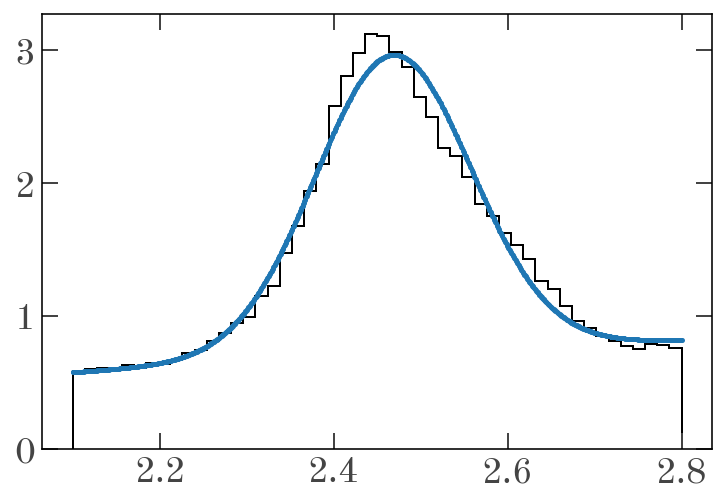

In [49]:
logg_lim = (2.1, 2.8)
opts = []
for l, r in list(zip(mh_bins[:-1], mh_bins[1:])) + [(mh_bins.min(), mh_bins.max())]:
# for l, r in [(mh_bins.min(), mh_bins.max())]:
    mask = (
        (metadata['M_H'] > l) &
        (metadata['M_H'] <= r) &
        (metadata['LOGG'] > logg_lim[0]) & 
        (metadata['LOGG'] < logg_lim[1])
    )
    logg_data = metadata['LOGG'][mask]
    
    with pm.Model() as model:
        mu = pm.Uniform('mu_logg', 2, 3)
        logsigma = pm.Uniform('logsigma_logg', -4, 1)
        sigma = tt.exp(logsigma)
        dist1 = pm.Normal.dist(mu, sigma)

        mu_bg = pm.Uniform('mu_bg', -5, 5)
        logsigma_bg = pm.Uniform('logsigma_bg', 0, 4)
        sigma_bg = tt.exp(logsigma_bg)
        dist2 = pm.TruncatedNormal.dist(mu_bg, sigma_bg, 
                                        lower=logg_lim[0], upper=logg_lim[1])

        w = pm.Dirichlet('w', a=np.array([1, 1]))
        lnlike = pm.Mixture('lnlike', w=w, comp_dists=[dist1, dist2], 
                            observed=logg_data)

        grid = np.linspace(*logg_lim, 1024)
        lnlike_grid1 = dist1.logp(grid) + tt.log(w[0])
        lnlike_grid2 = dist2.logp(grid) + tt.log(w[1])
        lnlike_grid = pm.logaddexp(lnlike_grid1, lnlike_grid2)
        
    with model:
        res = pmx.optimize(start={
            'mu_logg': 2.4, 'logsigma_logg': -2.3, 'mu_bg': 1, 'logsigma_bg': 2})
        shit = pmx.eval_in_model(lnlike_grid, point=res)
    
    opts.append(res)
    
    plt.figure()
    plt.hist(logg_data, 
             bins=50, density=True, histtype='step')
    plt.plot(grid, np.exp(shit))

In [52]:
np.array([opts[0]['mu_logg'], np.exp(opts[0]['logsigma_logg'])])

array([2.46796038, 0.08953375])

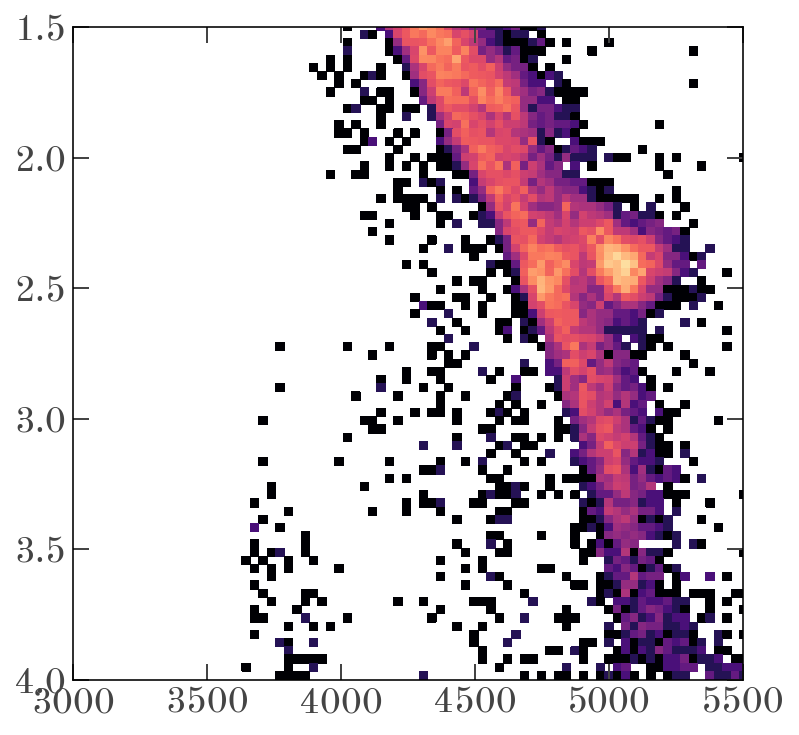

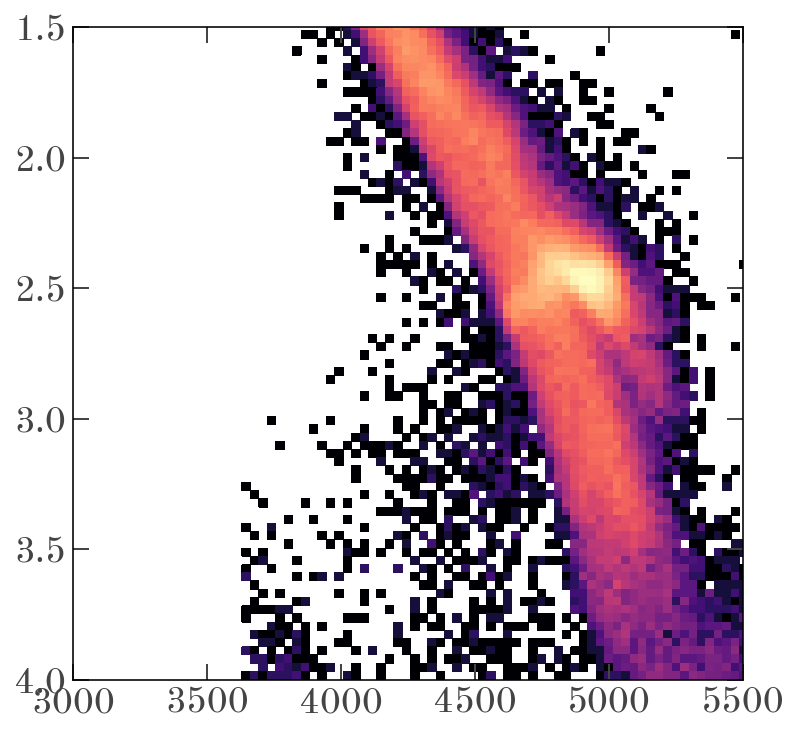

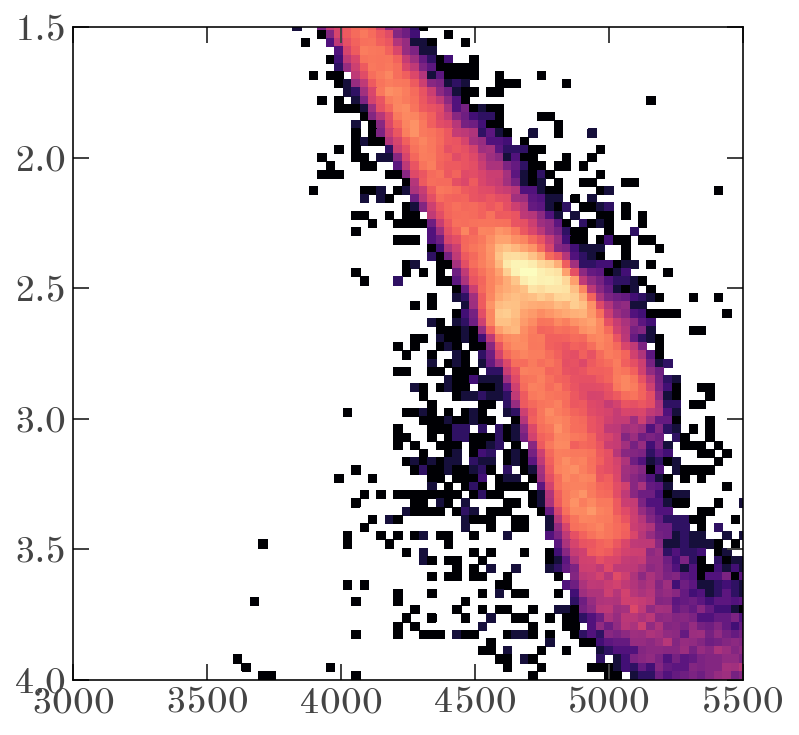

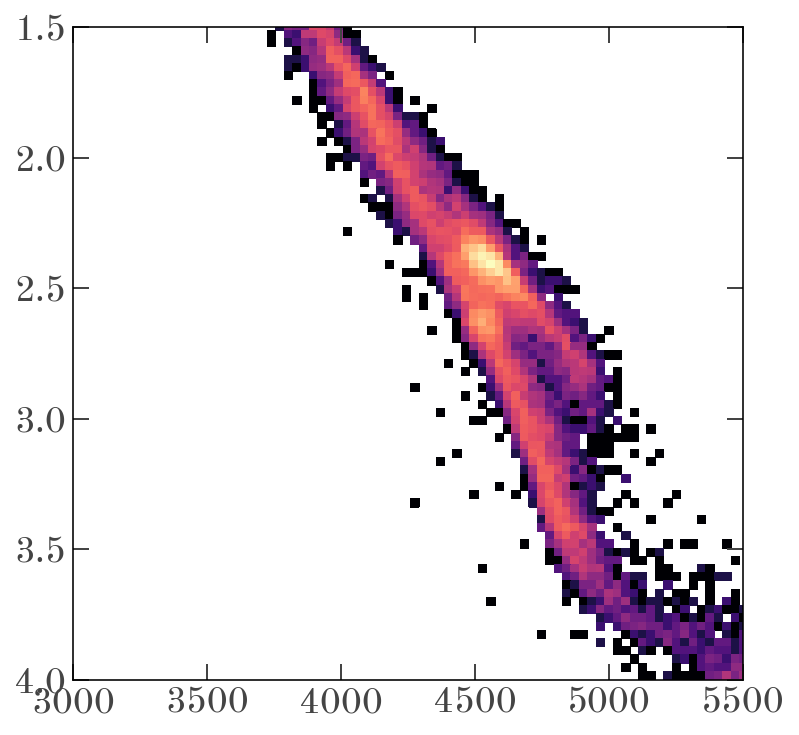

In [46]:
for l, r in zip(mh_bins[:-1], mh_bins[1:]):
    _mask = (metadata['M_H'] > l) & (metadata['M_H'] < r)
    
    plt.figure(figsize=(6, 6))
    plt.hist2d(
        metadata['TEFF'][_mask],
        metadata['LOGG'][_mask],
        bins=(np.linspace(3000, 7000, 128),
              np.linspace(0, 4, 128)),
        norm=mpl.colors.LogNorm()
    );
    plt.xlim(3e3, 5.5e3)
    plt.ylim(4, 1.5)